In [1]:
import numpy as np
from PIL import Image
import matplotlib as plt
from io import BytesIO
from math import log10, sqrt

In [7]:
def load_and_scale_images(image_path, watermark_path):
    image = Image.open(image_path).convert('L')  
    image = image.resize((512, 512))
    
    image_array = np.array(image)
    
    watermark = Image.open(watermark_path).convert('L')
    watermark = watermark.resize((32, 32))
    #watermark slika treba da se sastoji samo od crnih i belih piksela
    watermark_array = np.array(watermark) > 128
    watermark = Image.fromarray(watermark_array)
    
    return image_array, watermark_array, image, watermark

In [8]:
image_array,watermark_array,input_image, watermark_image=load_and_scale_images('lena.png','watermark_image.webp')

### Permutovanje redosleda piksela u watermark slici zarad veće sigurnosti

In [9]:
def shuffle_watermark_image(watermark_image):
    np.random.seed(42)

    wm_img_array = np.array(watermark_image) 
    shape = wm_img_array.shape

    wm_img_array = wm_img_array.flatten()

    indices = np.arange(wm_img_array.size)
    i_n = np.random.permutation(indices)

    shuffled_img_array = wm_img_array[i_n]

    shuffled_image_array = shuffled_img_array.reshape(shape)
    shuffled_image = Image.fromarray(shuffled_image_array)

    return shuffled_image, i_n

### Povratak slike u originalnu reprezentaciju

In [14]:
def unshuffle_watermark_image(shuffled_image, indices, seed=42):
    np.random.seed(seed)

    shuffled_img_array = np.array(shuffled_image) 
    shape = shuffled_img_array.shape

    shuffled_img_array_flat = shuffled_img_array.flatten()

    original_img_array = np.zeros_like(shuffled_img_array_flat)

    inverse_indices = np.argsort(indices)

    
    original_img_array = shuffled_img_array_flat[inverse_indices]

    original_image_array = original_img_array.reshape(shape)
    original_image = Image.fromarray(original_image_array)

    return original_image

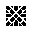

In [15]:
watermark_image

In [16]:
shuffled_watermark, indices = shuffle_watermark_image(watermark_image)

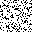

In [17]:
shuffled_watermark

### Robusna SVD watermarking tehnika se sastoji iz sledećih koraka:
- Podela slike na 4 jednaka dela => FTL (TOP LEFT), FTR (TOP RIGHT), FBL (BOTTOM LEFT) i FBR(BOTTOM RIGHT)
- Watermark slika se ugrađuje u dve slike => npr. FTL i FBR 
- Ugrađivanje se vrši pomoću SVD dekompozicije:
    - Deo slike u koju se ugrađuje watermark se deli na manje blokove. Broj blokova jednak je broju piksela u watermark slici.
    - Nad svakim blokom se vrši SVD dekompozicija, kojom se dobijaju 3 matrice: U, D, Vt.
    - U slučaju ugrađivanja watermarka u FTL, ugrađivanje je izvršeno nad matricama D, dok u slučaju ugrađivanja u FBR nad matricama U.
    - Duplo ugrađivanje watermarka doprinosi sigurnosti da watermark ne bude izgubljen prilikom različitih transformacija nad slikom sa ugrađenim watermarkom.
    

In [18]:
def split_image_into_four(image):

    width, height = image.size

    mid_width = width // 2
    mid_height = height // 2

    ftl = image.crop((0, 0, mid_width, mid_height))  
    ftr = image.crop((mid_width, 0, width, mid_height))  
    fbl = image.crop((0, mid_height, mid_width, height)) 
    fbr = image.crop((mid_width, mid_height, width, height))

    return ftl, ftr, fbl, fbr

In [19]:
def merge_image_from_four(ftl, ftr, fbl, fbr):
    width, height = ftl.size
    
    merged_image = Image.new('L', (width * 2, height * 2))

    merged_image.paste(ftl, (0, 0))  
    merged_image.paste(ftr, (width, 0)) 
    merged_image.paste(fbl, (0, height))  
    merged_image.paste(fbr, (width, height))

    return merged_image

In [20]:
import bisect

def find_interval(sorted_array, x):
    index = bisect.bisect_right(sorted_array, x)
    if index == len(sorted_array):
        return len(sorted_array) - 1
    return index

In [22]:
def reconstruct_image(blocks, original_indices, block_size):
    reconstruct_image = np.zeros((512 // 2, 512 // 2))
    for (U, D, Vt), (i,j) in zip(blocks, original_indices):
        D_matrix = np.diag(D)
        r_b = np.dot(U, np.dot(D_matrix, Vt))
        reconstruct_image[i:i+block_size,j: j+block_size] = r_b
    return reconstruct_image

###### Ugrađivanje watermarka u matrice D dela slike FTL
1. Podela FTL na manje blokove
2. Nad svakim blokom se izvršava SVD dekompozicija i čuvaju se dobijene matrice
3. Za svaki blok se pamti 1. (najveća) sopstvena vrednost iz matrice D
4. Na osnovu tih vrednosti pravi se ekvidistantna mreža pomoću koje će se vršiti ugrađivanje watermarka u sliku


In [26]:
d_large = []
d_new = []
blocks = []
def watermark_embedding_in_d_matrix(ftl, wm, block_size=8):
    global d_large, d_new, blocks
    original_indices = []
    wm_array = np.array(wm) 
    wm_array = wm_array.flatten().astype('uint64')
    ftl_arr = np.array(ftl)
    
    #podela ftl na manje blokove i izvrsavanje svd dekompozicije svakog bloka
    for i in range(0, ftl_arr.shape[0], block_size):
        for j in range(0, ftl_arr.shape[1], block_size):
            block = ftl_arr[i:i+block_size, j:j+block_size]
            U, D, V = np.linalg.svd(block)
            d_large.append(D[0])
            original_indices.append((i,j))
            blocks.append((U, D, V))
    
    #pravljenje ekvidistantne mreze
    T=60
    d_max = max(d_large)
    d_min = min(d_large)
    ds = np.linspace(d_min-T, d_max + T)
    
    
    bit_idx = 0
    for d in d_large:
        #pronalazak rednog broja intervala u koji d upada
        idx = find_interval(ds, d)
        
        #dohvatanje donje i gornje granice dohvacenog intervala
        dlow = ds[idx-1]
        dhigh = ds[idx]
        
        #ukoliko je trenutni bit watermarka koji se ugrađuje 1
        #d vrednost se ažurira tako što se više približava srednjoj vrednosti leve polovine intervala kojem pripada
        #analogno ukoliko je bit 0
        if wm_array[bit_idx] == 1:
            blocks[bit_idx][1][0] = (dlow + (dhigh + dlow)/2)/2
        else:
            blocks[bit_idx][1][0] = (dhigh + (dhigh + dlow)/2)/2
        d_new.append(blocks[bit_idx][1][0])
        bit_idx += 1
    
    #rekonstrukcija slike na osnovu blokova, tj dekomponovanih matrica njihovim mnozenjem
    result = reconstruct_image(blocks, original_indices, 8)
    return result

###### Ugrađivanje watermarka u matrice U dela slike FBR
1. Podela FBR na manje blokove
2. Nad svakim blokom se izvršava SVD dekompozicija i čuvaju se dobijene matrice
3. Za svaki blok posmatra se prva kolona matrice U, tj razlika prve dve vrednosti iz te kolone
4. U zavisnosti od vrednosti te razlike, prvi i drugi element te kolone se ažuriraju i na taj način se obezbeđuje ugradnja watermarka

In [27]:
def watermark_embedding_in_u_matrix(fbr, wm, block_size=8, alpha=0.0):
    fbr_arr = np.array(fbr)
    wm_array = np.array(wm).flatten().astype('uint64')

    original_indices = []
    blocks = []
    
    #podela fbr na manje blokove i izvrsavanje svd dekompozicije svakog bloka
    for i in range(0, fbr_arr.shape[0], block_size):
        for j in range(0, fbr_arr.shape[1], block_size):
            block = fbr_arr[i:i+block_size, j:j+block_size]
            U, D, V = np.linalg.svd(block)
            original_indices.append((i,j))
            blocks.append((U, D, V))

    bit_idx = 0
    #za svaki blok posmatra se razlika prve dve vrednosti iz prve kolone matrice U
    for U, D, V in blocks:
        u_diff = abs(U[0, 0]) - abs(U[1, 0])
        
        if (wm_array[bit_idx] == 1 and u_diff > alpha) or (wm_array[bit_idx]==0 and u_diff<alpha):
            U[1,0]=-abs(abs(U[1,0])-(alpha-u_diff)/2)
            U[0,0]=-abs(abs(U[0,0])+(alpha-u_diff)/2)
        elif (wm_array[bit_idx] == 1 and u_diff < alpha) or (wm_array[bit_idx]==0 and u_diff>alpha):
            U[1,0]=-abs(abs(U[1,0])-(alpha+u_diff)/2)
            U[0,0]=-abs(abs(U[0,0])+(alpha+u_diff)/2)
        bit_idx += 1

    reconstructed_fbr = reconstruct_image(blocks, original_indices, block_size)
    return reconstructed_fbr

In [28]:
def watermak_embedding(image, wm):
    ftl, ftr, fbl, fbr = split_image_into_four(input_image)
    
    #ugradjivanje watermarka u ftl
    ftl_new = watermark_embedding_in_d_matrix(ftl, wm)
    ftl_new = Image.fromarray(ftl_new)
    ftl_new.show()
    
    #ugradjivanje watermarka u fbr
    fbr_new = watermark_embedding_in_u_matrix(fbr, wm)
    fbr_new = Image.fromarray(fbr_new)
    fbr_new.show()
    
    #rekonstrukcija slike nakon ugradjenog watermarka u ftl i fbr
    merged_image = merge_image_from_four(ftl_new, ftr, fbl, fbr_new)
    merged_image.show()
    merged_image.save('watermarked_image.png')
    
    return merged_image

In [29]:
watermarked_image = watermak_embedding(input_image, shuffled_watermark)

##### Dohvatanje skrivenog watermarka unutar FTL

In [33]:
ftl_new, _, _, fbr_new = split_image_into_four(watermarked_image)

In [34]:
#ekvidistantna mreza:
T=60
d_max = max(d_large)
d_min = min(d_large)
ds = np.linspace(d_min-T, d_max + T)

In [35]:
def extract_watermark_from_d_matrix(ftl,watermark_size=(32, 32), block_size=8):
    
    ftl_arr = np.array(ftl)

    extraxted_watermark = []
    
    for i in range(0, ftl_arr.shape[0], block_size):
        for j in range(0, ftl_arr.shape[1], block_size):
            block = ftl_arr[i:i+block_size, j:j+block_size]
            U, D, Vt = np.linalg.svd(block)
            
            #dohvatanje najvece singularne vrednosti iz matrice D
            d = D[0]
            
            #pronalazak odgovarajuceg intervala kojem singularna vrednost pripada
            idx = find_interval(ds, d)
            dh = ds[idx]
            dl = ds[idx-1]
            
            #ukoliko se signularna vrednost nalazi u levoj polovini odgovarajuceg intervala
            #onda vrednost odgovarajuceg piksela watermarka 1, analogno za desnu polovinu
            if  d < ((dl+dh)/2):
                extraxted_watermark.append(1)
            else:
                extraxted_watermark.append(0)

    extraxted_watermark_result = np.array(extraxted_watermark).reshape((32,32))
    return extraxted_watermark_result

In [36]:
res = extract_watermark_from_d_matrix(ftl_new)

###### Dohvatanje watermarka koji ima permutovane bitove

In [37]:
watermark1_extracted = Image.fromarray(res.astype(np.uint8)*255)

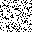

In [38]:
watermark1_extracted

###### Dobijanje originalnog watermarka na osnovu ključa koji samo vlasnik zna

In [39]:
original_watermark1_extracted = unshuffle_watermark_image(watermark1_extracted, indices)

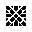

In [40]:
original_watermark1_extracted

###### Dohvatanje skrivenog watermarka unutar FBR

In [43]:
def extract_watermark_from_u_matrix(fbr, watermark_size=(32, 32), block_size=8):
    fbr_arr = np.array(fbr)
    extracted_watermark = []
    
    for i in range(0, fbr_arr.shape[0], block_size):
        for j in range(0, fbr_arr.shape[1], block_size):
            block = fbr_arr[i:i+block_size, j:j+block_size]
            U, D, Vt = np.linalg.svd(block)
            
            if abs(U[0,0])>abs(U[1,0]):
                extracted_watermark.append(0)
            else:
                extracted_watermark.append(1)
    
    extracted_watermark = np.array(extracted_watermark).reshape(watermark_size)
    return extracted_watermark


In [44]:
watermark2_fbr = extract_watermark_from_u_matrix(fbr_new)

In [45]:
watermark2_extracted = Image.fromarray(watermark2_fbr.astype(np.uint8)*255)

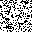

In [46]:
watermark2_extracted

In [47]:
original_watermark2_extracted = unshuffle_watermark_image(watermark2_extracted, indices)

###### Može se primetiti kako je u ovom slučaju watermark lošije očuvan unutar slike

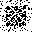

In [48]:
original_watermark2_extracted

### Primenom određenih transformacija nad slikom koja sadrži watermark može se desiti da watermark bude ''oštećen''. U nekim slučajevima će watermark dohvaćen iz matrica D biti bolje očuvan, a u nekim slučajevima iz matrice U, zbog čega smo watermark i uneli u oba dela slike.

# Transformacije koje će biti primenjene nad slikom sa watermarkom

###### Kompresovanje slike u JPEG format koje može uticati na kvalitet skrivenog watermarka

In [53]:
def compress_image(image, quality):
    buffer = BytesIO()
    image.save(buffer, format="JPEG", quality=quality)
    compressed_image = Image.open(buffer)
    return compressed_image

###### Transformacija kojom se slika skalira a potom vraća na prvobitnu veličinu, što takođe može uticati na kvalitet skrivenog watermarka

In [55]:
def resize_and_restore_image(image, target_size=(256, 256), original_size=(512, 512)):
    scaled_down_image = image.resize(target_size, Image.BILINEAR)
    restored_image = scaled_down_image.resize(original_size, Image.BILINEAR)
    return restored_image

###### Promena osvetljenja slike 

In [56]:
from PIL import ImageEnhance

def adjust_brightness(image, factor):
    #factor 1.2 increases brightness for 20%
    #factor 0.8 decreases brightness for 20%
    enhancer = ImageEnhance.Brightness(image)
    adjusted_image = enhancer.enhance(factor)
    return adjusted_image

###### Tranformacija koja nasumično unosi crne i bele piksele unutar slike sa skrivenim watermarkom

In [57]:
def salt_and_pepper_noise(image, density=0.01):
    image_array = np.array(image)
    output = np.copy(image_array)

    num_salt = np.ceil(density * image_array.size * 0.5)
    num_pepper = np.ceil(density * image_array.size * 0.5)

    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image_array.shape]
    output[tuple(coords)] = 255

    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image_array.shape]
    output[tuple(coords)] = 0

    return Image.fromarray(output)

###### Transformacija koja menja svetlinu slike korišenjem gama korekcije

In [58]:
def gamma_correction(image, gamma):
    
    img_array = np.array(image)
    img_normalized = img_array / 255.0
   
    img_gamma_corrected = np.power(img_normalized, gamma)
    
    img_corrected = (img_gamma_corrected * 255).astype(np.uint8)
    
    corrected_image = Image.fromarray(img_corrected)

    return corrected_image

###### Transformacija koja svaki piksel menja medijanom vrednosti svojih suseda

In [59]:
def median_filter(image):
    img_array = np.array(image)
    
    height, width = img_array.shape
    
    filtered_image = np.zeros((height, width), dtype=np.uint8)
    
    for i in range(1, height - 1):
        for j in range(1, width - 1):
            #3x3 kernel
            kernel = img_array[i-1:i+2, j-1:j+2].flatten()

            median_value = np.median(kernel)
            filtered_image[i, j] = median_value
    
    return Image.fromarray(filtered_image)

#### Metrike za proveru kvaliteta transformisane slike u odnosu na originalnu

## PSNR (Peak Signal-to-Noise Ratio)

Matematička formula za računanje PSNR:

$ PSNR = 10 * \log_{10}((MAX)^2/MSE) $

MAX = maksimalna vrednost piksela u slici

MSE = srednje kvadratna razlika izmedju vrednosti piksela originalne i transformisane slike

Vrednosti PSNR $\in(30,40)$ oznčavaju da je kvalitet transformisane slike dobar, vrednosti manje od ovih označavaju da je kvalitet loš, a vrednosti koje su veće da je kvalitet veoma dobar 

In [60]:
def psnr(original, compressed):
    original = np.array(original)
    compressed = np.array(compressed)
    mse = np.mean((original - compressed) ** 2)
    if mse == 0:  # slike su identične
        return 100
    max_pixel = 255.0
    return 10 * log10(max_pixel ** 2 / mse)

## BER (Bit Error Rate)

Ova metrika se koristi za procenu kvatiteta dohvaćenoj watermarka pre i nakon transformacije slike sa ugrađenim watermarkom.
Meri procenat bitova koji su pogrešno dohvaćeni u odnosu na originalan watermark.

$ BER = \frac{Number of Incorrect Bits}{Total Number of Bits} $

Poželjno je da vrednost BER-a bude što manja.

In [61]:
def ber(original_watermark, extracted_watermark):
    original_watermark = np.array(original_watermark).flatten()
    extracted_watermark = np.array(extracted_watermark).flatten() > 128
    total_bits = len(original_watermark)
    error_bits = np.sum(original_watermark != extracted_watermark)
    return error_bits / total_bits

## NC (Normalized Correlation)

Mera sličnosti između originalne i transformisane slike. Vrednosti nad kojima se ova metrika računa moraju biti normalizovane, tj u opsegu između 0 i 1.

$ NC = \frac{\sum(O_{i},E_{i})}{\sqrt{\sum{O_{i}^2}*\sum{E_{i}^2}}}$

$O_{i}$ - vrednosti iz originalne slike.
$E_{i}$ - vrednosti iz transformisane slike.

Poželjno je da vrednost NC-a bude što bliža 1.


In [62]:
def nc(original_watermark, extracted_watermark):
    original_watermark = np.array(original_watermark).flatten()
    extracted_watermark = np.array(extracted_watermark).flatten()

    numerator = np.sum(original_watermark * extracted_watermark)
    denominator = np.sqrt(np.sum(original_watermark ** 2) * np.sum(extracted_watermark ** 2))
    
    if denominator == 0:
        return 0
    
    return numerator / denominator

In [63]:
def normalize_watermark(watermark):
    watermark = np.array(watermark)
    max_val = np.max(watermark)
    min_val = np.min(watermark)
    
    if max_val - min_val == 0:
        return watermark  # Ako su sve vrednosti iste
    
    return (watermark - min_val) / (max_val - min_val)


## Izračunavanje metrika za različite transformacije

###### Provera koliko watermarking tehnika utiče na kvalitet originalne slike

In [64]:
psnr_value_watermarking = psnr(input_image, watermarked_image)
psnr_value_watermarking

47.81901275555902

In [65]:
original_watermark1_extracted_normalized = normalize_watermark(original_watermark1_extracted)
original_watermark2_extracted_normalized = normalize_watermark(original_watermark2_extracted)

In [69]:
nc_value1 = nc(watermark_image, original_watermark1_extracted_normalized)
nc_value2 = nc(watermark_image, original_watermark2_extracted_normalized)

ber_value1 = ber(watermark_image, original_watermark1_extracted)
ber_value2 = ber(watermark_image, original_watermark2_extracted)

print('Kvalitet watermarka iz FTL:')
print(f'\tBER1 {ber_value1}')
print(f'\tNC1 {nc_value1}')

print('Kvalitet watermarka iz FBR:')
print(f'\tBER2 {ber_value2}')
print(f'\tNC2 {nc_value2}')

Kvalitet watermarka iz FTL:
	BER1 0.0
	NC1 1.0
Kvalitet watermarka iz FBR:
	BER2 0.15625
	NC2 0.8918186632416427


## Kompresovanje slike 

In [74]:
compressed_image = compress_image(watermarked_image, 70)

In [75]:
psnr_value_compress = psnr(input_image, compressed_image)
psnr_value_compress

37.46426574963655

In [76]:
ftl_compress, _, _ ,fbr_compress = split_image_into_four(compressed_image)

watermark1_extracted_compress = extract_watermark_from_d_matrix(ftl_compress)
watermark1_extracted_compress = Image.fromarray(watermark1_extracted_compress.astype(np.uint8)*255)
watermark1_extracted_compress_original = unshuffle_watermark_image(watermark1_extracted_compress, indices)

watermark2_extracted_compress = extract_watermark_from_u_matrix(fbr_compress)
watermark2_extracted_compress = Image.fromarray(watermark2_extracted_compress.astype(np.uint8)*255)
watermark2_extracted_compress_original = unshuffle_watermark_image(watermark2_extracted_compress, indices)

In [77]:
ber1_value_compression = ber(watermark_image, watermark1_extracted_compress_original)
ber2_value_compression = ber(watermark_image, watermark2_extracted_compress_original)

normalized_watermark1 = normalize_watermark(watermark1_extracted_compress_original)
normalized_watermark2 = normalize_watermark(watermark2_extracted_compress_original)

nc1_value_compression = nc(watermark_image, normalized_watermark1)
nc2_value_compression = nc(watermark_image, normalized_watermark2)

print('Kvalitet watermarka iz FTL:')
print(f'\tBER1 {ber1_value_compression}')
print(f'\tNC1 {nc1_value_compression}')

print('Kvalitet watermarka iz FBR:')
print(f'\tBER2 {ber2_value_compression}')
print(f'\tNC2 {nc2_value_compression}')

Kvalitet watermarka iz FTL:
	BER1 0.107421875
	NC1 0.9261481919632786
Kvalitet watermarka iz FBR:
	BER2 0.3505859375
	NC2 0.7470557317774703


###### Dohvatanje watermarka iz kompresovane slike iz dela FTL

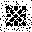

In [79]:
watermark1_extracted_compress_original

###### Dohvatanje watermarka iz kompresovane slike iz dela FBR

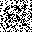

In [81]:
watermark2_extracted_compress_original

## Skaliranje slike i vraćanje u originalnu dimenziju

In [82]:
resized_image = resize_and_restore_image(watermarked_image)

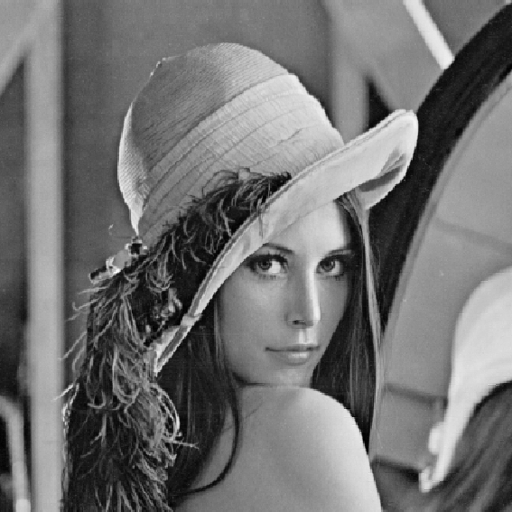

In [83]:
watermarked_image

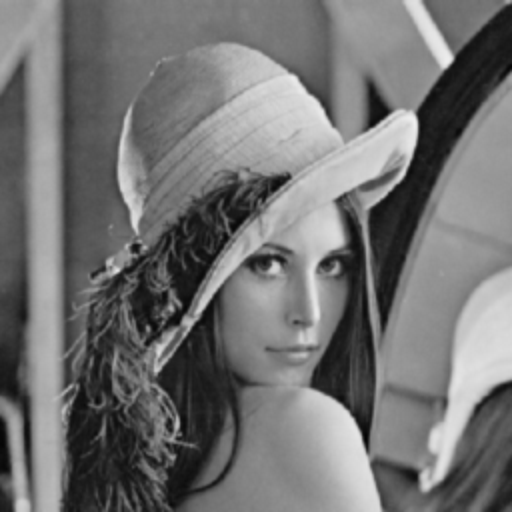

In [66]:
resized_image

In [84]:
psnr_value_resize = psnr(input_image, resized_image)
psnr_value_resize

34.34240961910524

In [85]:
ftl_resize, _, _ ,fbr_resize = split_image_into_four(resized_image)

In [86]:
watermark1_extracted_resize = extract_watermark_from_d_matrix(ftl_resize)
watermark1_extracted_resize = Image.fromarray(watermark1_extracted_resize.astype(np.uint8)*255)
watermark1_extracted_resize_original = unshuffle_watermark_image(watermark1_extracted_resize, indices)

watermark2_extracted_resize = extract_watermark_from_u_matrix(ftl_resize)
watermark2_extracted_resize = Image.fromarray(watermark2_extracted_resize.astype(np.uint8)*255)
watermark2_extracted_resize_original = unshuffle_watermark_image(watermark2_extracted_resize, indices)

In [87]:
ber1_value_resize = ber(watermark_image, watermark1_extracted_resize_original)
ber2_value_resize = ber(watermark_image, watermark2_extracted_resize_original)

normalized_watermark1_resize = normalize_watermark(watermark1_extracted_resize_original)
normalized_watermark2_resize = normalize_watermark(watermark2_extracted_resize_original)

nc1_value_resize = nc(watermark_image, normalized_watermark1_resize)
nc2_value_resize = nc(watermark_image, normalized_watermark2_resize)

In [89]:
print('Kvalitet watermarka iz FTL:')
print(f'\tBER1 {ber1_value_resize}')
print(f'\tNC1 {nc1_value_resize}')

print('Kvalitet watermarka iz FBR:')
print(f'\tBER2 {ber2_value_resize}')
print(f'\tNC2 {nc2_value_resize}')

Kvalitet watermarka iz FTL:
	BER1 0.1943359375
	NC1 0.8644462235857158
Kvalitet watermarka iz FBR:
	BER2 0.5576171875
	NC2 0.5598558701691863


###### Dohvatanje watermarka iz skalirane slike iz dela FTL

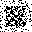

In [76]:
watermark1_extracted_resize_original

###### Dohvatanje watermarka iz skalirane slike iz dela FBR

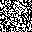

In [91]:
watermark2_extracted_resize_original

## Povecanje osvetljenja slike za 20%

In [127]:
brighted_image = adjust_brightness(watermarked_image,factor=1.2)

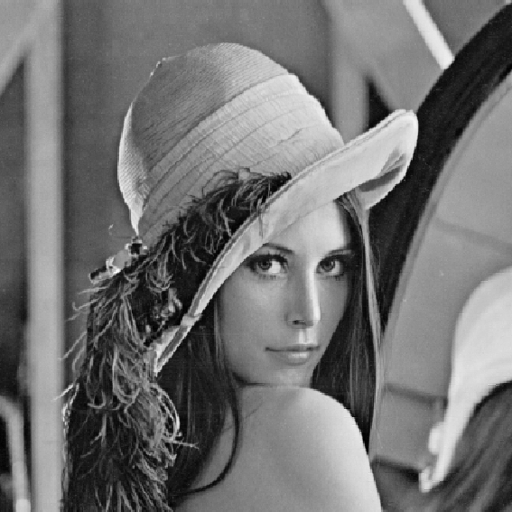

In [128]:
watermarked_image

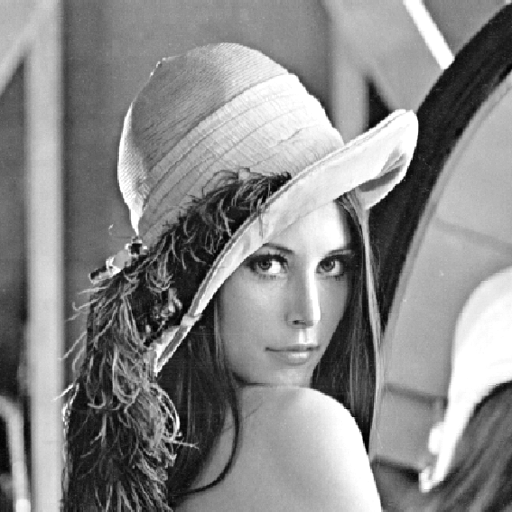

In [129]:
brighted_image

In [130]:
psnr_value_bright = psnr(input_image, brighted_image)
psnr_value_bright

27.8929930328307

In [131]:
ftl_bright, _, _ ,fbr_bright = split_image_into_four(brighted_image)

In [132]:
watermark1_extracted_bright = extract_watermark_from_d_matrix(ftl_bright)
watermark1_extracted_bright = Image.fromarray(watermark1_extracted_bright.astype(np.uint8)*255)
watermark1_extracted_bright_original = unshuffle_watermark_image(watermark1_extracted_bright, indices)

watermark2_extracted_bright = extract_watermark_from_u_matrix(ftl_bright)
watermark2_extracted_bright = Image.fromarray(watermark2_extracted_bright.astype(np.uint8)*255)
watermark2_extracted_bright_original = unshuffle_watermark_image(watermark2_extracted_bright, indices)

In [133]:
ber1_value_bright = ber(watermark_image, watermark1_extracted_bright_original)
ber2_value_bright = ber(watermark_image, watermark2_extracted_bright_original)

normalized_watermark1_bright = normalize_watermark(watermark1_extracted_bright_original)
normalized_watermark2_bright = normalize_watermark(watermark2_extracted_bright_original)

nc1_value_bright = nc(watermark_image, normalized_watermark1_bright)
nc2_value_bright = nc(watermark_image, normalized_watermark2_bright)

In [134]:
print('Kvalitet watermarka iz FTL:')
print(f'\tBER1 {ber1_value_bright}')
print(f'\tNC1 {nc1_value_bright}')

print('Kvalitet watermarka iz FBR:')
print(f'\tBER2 {ber2_value_bright}')
print(f'\tNC2 {nc2_value_bright}')

Kvalitet watermarka iz FTL:
	BER1 0.501953125
	NC1 0.6059358371589929
Kvalitet watermarka iz FBR:
	BER2 0.494140625
	NC2 0.6220261208940596


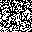

In [135]:
watermark1_extracted_bright_original

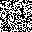

In [136]:
watermark2_extracted_bright_original

## Salt and Pepper Noise


In [137]:
noisy_image = salt_and_pepper_noise(watermarked_image)

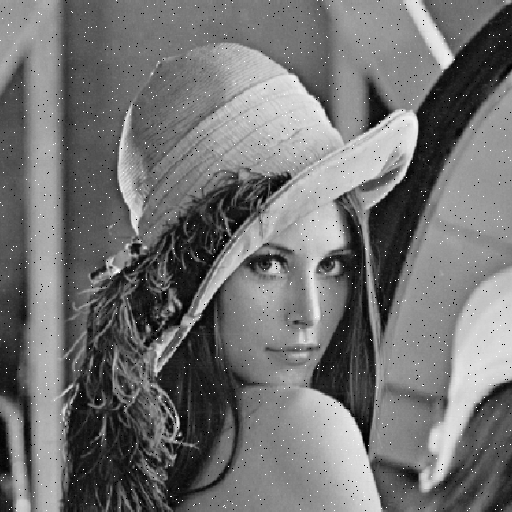

In [138]:
noisy_image

In [140]:
psnr_value_noisy = psnr(input_image, noisy_image)
psnr_value_noisy

44.875401952919304

In [141]:
ftl_noisy, _, _ ,fbr_noisy = split_image_into_four(noisy_image)

In [142]:
watermark1_extracted_noisy = extract_watermark_from_d_matrix(ftl_noisy)
watermark1_extracted_noisy = Image.fromarray(watermark1_extracted_noisy.astype(np.uint8)*255)
watermark1_extracted_noisy_original = unshuffle_watermark_image(watermark1_extracted_noisy, indices)

watermark2_extracted_noisy = extract_watermark_from_u_matrix(ftl_noisy)
watermark2_extracted_noisy = Image.fromarray(watermark2_extracted_noisy.astype(np.uint8)*255)
watermark2_extracted_noisy_original = unshuffle_watermark_image(watermark2_extracted_noisy, indices)

In [143]:
ber1_value_noisy = ber(watermark_image, watermark1_extracted_noisy_original)
ber2_value_noisy = ber(watermark_image, watermark2_extracted_noisy_original)

normalized_watermark1_noisy = normalize_watermark(watermark1_extracted_noisy_original)
normalized_watermark2_noisy = normalize_watermark(watermark2_extracted_noisy_original)

nc1_value_noisy = nc(watermark_image, normalized_watermark1_noisy)
nc2_value_noisy = nc(watermark_image, normalized_watermark2_noisy)

In [144]:
print('Kvalitet watermarka iz FTL:')
print(f'\tBER1 {ber1_value_noisy}')
print(f'\tNC1 {nc1_value_noisy}')

print('Kvalitet watermarka iz FBR:')
print(f'\tBER2 {ber2_value_noisy}')
print(f'\tNC2 {nc2_value_noisy}')

Kvalitet watermarka iz FTL:
	BER1 0.3427734375
	NC1 0.7485394338621664
Kvalitet watermarka iz FBR:
	BER2 0.50390625
	NC2 0.6109841245839551


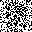

In [146]:
watermark1_extracted_noisy_original

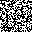

In [147]:
watermark2_extracted_noisy_original

## Promena osvetljenja gama korekcijom $\gamma = 0.9$

In [148]:
image_gamma = apply_gamma_correction(watermarked_image, 0.9)

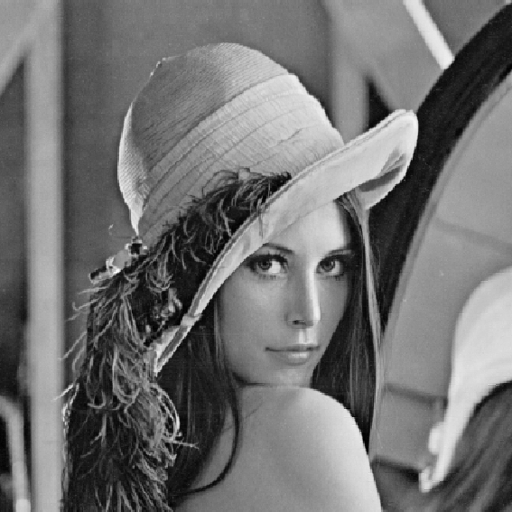

In [149]:
watermarked_image

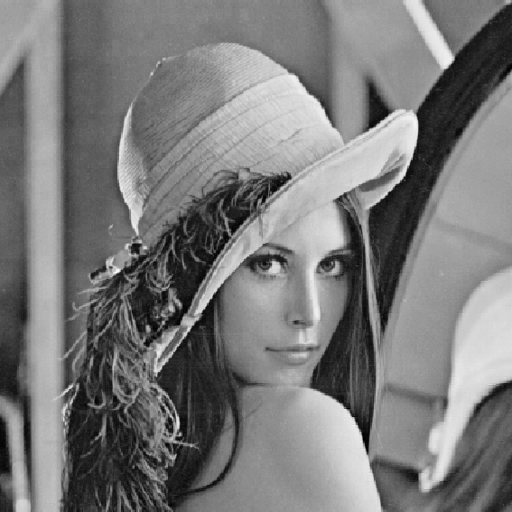

In [109]:
image_gamma

In [154]:
psnr_value_gamma = psnr(watermarked_image,image_gamma)
psnr_value_gamma

30.41897219338197

In [155]:
ftl_gamma, _, _, fbr_gamma = split_image_into_four(image_gamma)

In [156]:
watermark1_extracted_gamma = extract_watermark_from_d_matrix(ftl_gamma)
watermark1_extracted_gamma = Image.fromarray(watermark1_extracted_gamma.astype(np.uint8)*255)
watermark1_extracted_gamma_original = unshuffle_watermark_image(watermark1_extracted_gamma, indices)

watermark2_extracted_gamma = extract_watermark_from_u_matrix(fbr_gamma)
watermark2_extracted_gamma = Image.fromarray(watermark2_extracted_gamma.astype(np.uint8)*255)
watermark2_extracted_gamma_original = unshuffle_watermark_image(watermark2_extracted_gamma, indices)

In [157]:
ber1_value_gamma = ber(watermark_image, watermark1_extracted_gamma_original)
ber2_value_gamma = ber(watermark_image, watermark2_extracted_gamma_original)

normalized_watermark1_gamma = normalize_watermark(watermark1_extracted_gamma_original)
normalized_watermark2_gamma = normalize_watermark(watermark2_extracted_gamma_original)

nc1_value_gamma = nc(watermark_image, normalized_watermark1_gamma)
nc2_value_gamma = nc(watermark_image, normalized_watermark2_gamma)

In [159]:
print('Kvalitet watermarka iz FTL:')
print(f'\tBER1 {ber1_value_gamma}')
print(f'\tNC1 {nc1_value_gamma}')

print('Kvalitet watermarka iz FBR:')
print(f'\tBER2 {ber2_value_gamma}')
print(f'\tNC2 {nc2_value_gamma}')

Kvalitet watermarka iz FTL:
	BER1 0.228515625
	NC1 0.8384337688263459
Kvalitet watermarka iz FBR:
	BER2 0.1533203125
	NC2 0.8936952649271432


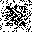

In [160]:
watermark1_extracted_gamma_original

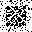

In [161]:
watermark2_extracted_gamma_original

## Filter sa medijanom

In [168]:
image_median = median_filter(watermarked_image)

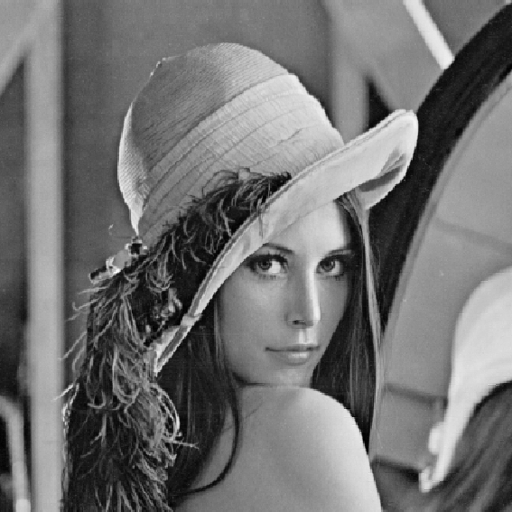

In [169]:
watermarked_image

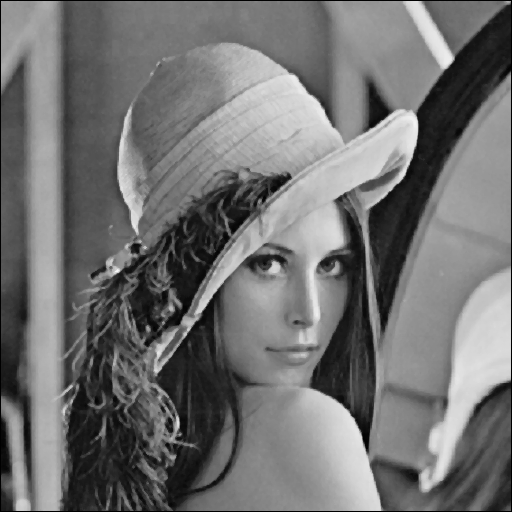

In [170]:
image_median

In [172]:
ftl_median, _, _, fbr_median = split_image_into_four(image_median)

watermark1_extracted_median = extract_watermark_from_d_matrix(ftl_median)
watermark1_extracted_median = Image.fromarray(watermark1_extracted_median.astype(np.uint8)*255)
watermark1_extracted_median_original = unshuffle_watermark_image(watermark1_extracted_median, indices)

watermark2_extracted_median = extract_watermark_from_u_matrix(ftl_median)
watermark2_extracted_median = Image.fromarray(watermark2_extracted_median.astype(np.uint8)*255)
watermark2_extracted_median_original = unshuffle_watermark_image(watermark2_extracted_median, indices)

In [173]:
ber1_value_median = ber(watermark_image, watermark1_extracted_median_original)
ber2_value_median = ber(watermark_image, watermark2_extracted_median_original)

normalized_watermark1_median = normalize_watermark(watermark1_extracted_median_original)
normalized_watermark2_median = normalize_watermark(watermark2_extracted_median_original)

nc1_value_median = nc(watermark_image, normalized_watermark1_median)
nc2_value_median = nc(watermark_image, normalized_watermark2_median)

In [174]:
print('Kvalitet watermarka iz FTL:')
print(f'\tBER1 {ber1_value_median}')
print(f'\tNC1 {nc1_value_median}')

print('Kvalitet watermarka iz FBR:')
print(f'\tBER2 {ber2_value_median}')
print(f'\tNC2 {nc2_value_median}')

Kvalitet watermarka iz FTL:
	BER1 0.216796875
	NC1 0.8487394145063657
Kvalitet watermarka iz FBR:
	BER2 0.57421875
	NC2 0.5528302968086627


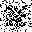

In [175]:
watermark1_extracted_median_original

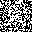

In [176]:
watermark2_extracted_median_original